In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 43.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=6980eb648d679c60b024a9e4409086bcbc3e4abf86b5a2a97232fd82a0fa7fa9
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=1ad88ca1df4a97caf26d61827ecfaf6cb64303befb4d0ffc8e8c33fdb8604db7
  Stored in directory: /root/.cache/pip/w

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 18.62 MiB/s, done.


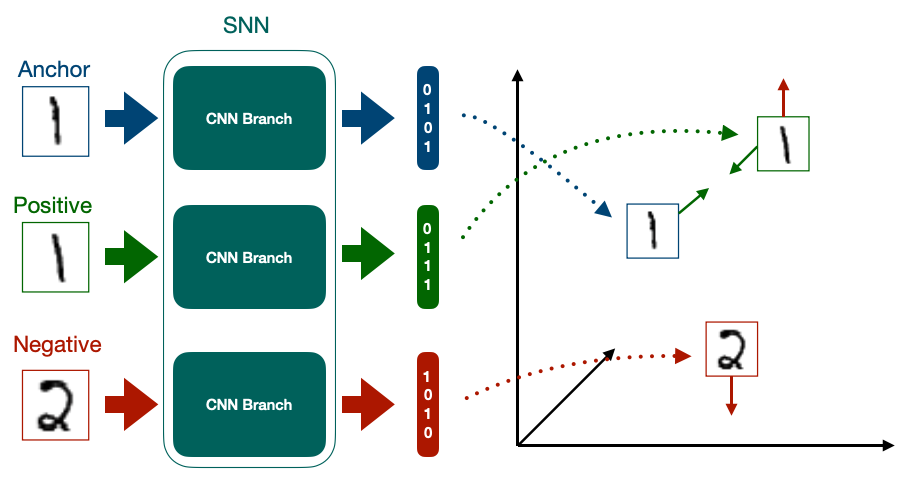

# Imports

In [ ]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[396]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

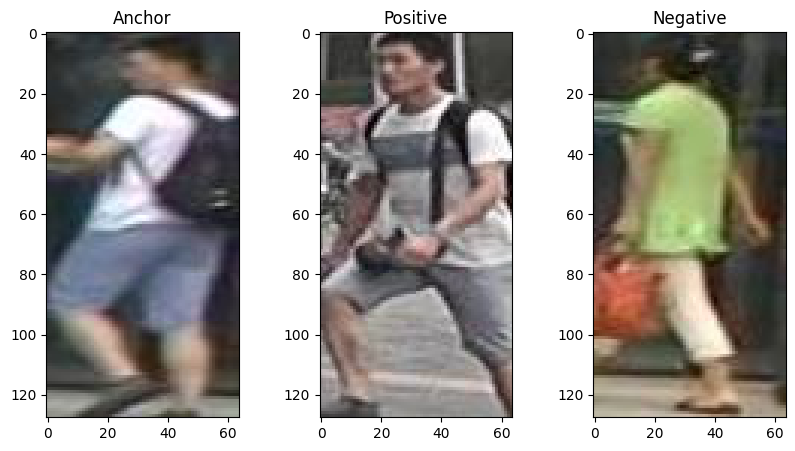

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Create APN Dataset 

In [ ]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of the trainset: {len(trainset)}")
print(f"Size of the validset: {len(validset)}")

Size of the trainset: 3200
Size of the validset: 800


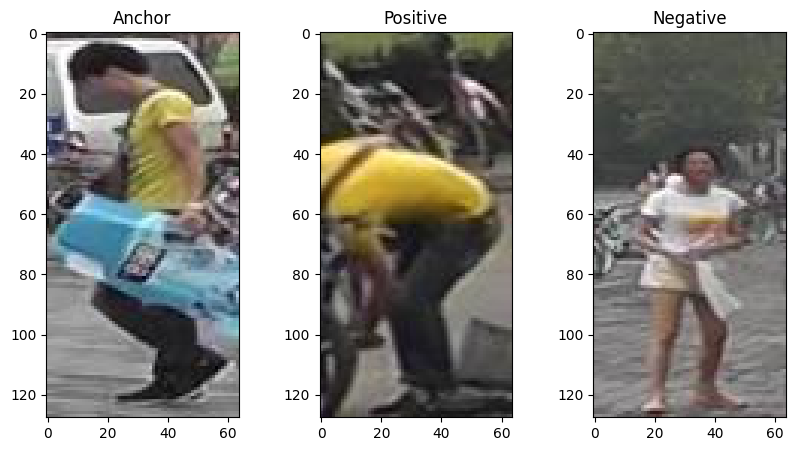

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True) 
validloader = DataLoader(validset, batch_size = BATCH_SIZE) 

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
  break
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [ ]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained= True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, image):
    embeddings = self.efficientnet(image)
    return embeddings

In [ ]:
model = APN_Model()
model.to(DEVICE);

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, criterion):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}")


100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 1 train_loss: 0.6236645185947418 valid_loss: 0.5802815937995911


100%|██████████| 25/25 [00:02<00:00,  8.97it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 2 train_loss: 0.3050140315294266 valid_loss: 0.42309212625026704


100%|██████████| 25/25 [00:02<00:00,  8.52it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 3 train_loss: 0.18914585262537004 valid_loss: 0.25281286239624023


100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 4 train_loss: 0.07920909762382507 valid_loss: 0.22998426735401153


100%|██████████| 25/25 [00:02<00:00, 10.01it/s]


EPOCHS: 5 train_loss: 0.07378295391798019 valid_loss: 0.24518254697322844


100%|██████████| 25/25 [00:02<00:00,  9.37it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 6 train_loss: 0.11975325286388397 valid_loss: 0.20405241787433626


100%|██████████| 25/25 [00:03<00:00,  8.22it/s]


EPOCHS: 7 train_loss: 0.09772609539330006 valid_loss: 0.29528700530529023


100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 8 train_loss: 0.06843084298074245 valid_loss: 0.18498153746128082


100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


EPOCHS: 9 train_loss: 0.041799901127815245 valid_loss: 0.2016213697195053


100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 10 train_loss: 0.0362878093123436 valid_loss: 0.16619004368782042


100%|██████████| 25/25 [00:02<00:00,  8.35it/s]


EPOCHS: 11 train_loss: 0.032833683863282205 valid_loss: 0.2259132206439972


100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


EPOCHS: 12 train_loss: 0.04811352655291557 valid_loss: 0.1995804288983345


100%|██████████| 25/25 [00:02<00:00, 10.03it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 13 train_loss: 0.034661946147680284 valid_loss: 0.1558058476448059


100%|██████████| 25/25 [00:02<00:00,  8.93it/s]


EPOCHS: 14 train_loss: 0.028322760462760926 valid_loss: 0.16800924122333527


100%|██████████| 25/25 [00:02<00:00,  8.97it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS: 15 train_loss: 0.032921282574534416 valid_loss: 0.12993438452482223


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis=1)

    return df_enc

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:41<00:00, 97.03it/s] 


In [ ]:
df_enc.to_csv('database.csv', index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.267896,0.304357,-0.321458,0.954506,0.621100,0.384784,-0.159128,0.176716,0.364328,...,-0.021794,-0.069994,-0.515672,0.322192,-1.422963,0.928929,0.455372,-0.373754,-1.148387,-0.567457
1,1420_c3s3_061978_03.jpg,-0.292951,0.347193,-0.342633,0.984189,0.705934,-0.072237,-0.248578,0.104671,0.308469,...,-0.131184,-0.060665,-0.270459,0.338125,-1.212965,0.785519,0.372452,-0.667238,-1.006916,-0.688992
2,1420_c5s3_062565_05.jpg,-0.219812,0.357347,-0.342423,1.101032,0.787051,0.331148,-0.136093,0.308403,0.292806,...,-0.367155,-0.125472,-0.369852,0.198131,-1.279756,0.864178,0.545946,-0.574022,-1.242255,-0.656478
3,1420_c6s3_085592_04.jpg,-0.019457,0.166828,-0.629982,0.686084,0.827796,0.313605,0.132180,0.005332,0.172818,...,0.024694,0.001766,-0.748133,0.152689,-1.107285,0.894277,0.155515,-0.222272,-1.016529,-0.437849
4,0663_c5s3_085987_03.jpg,0.221935,-0.481258,0.625981,-1.562186,-0.943075,0.311663,0.728949,-0.177469,-0.578053,...,0.826536,0.170220,-0.230501,0.278111,0.618311,-0.796148,0.019088,1.177781,0.518105,0.748942


# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [ ]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []
for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i: i+1, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.9/dist-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


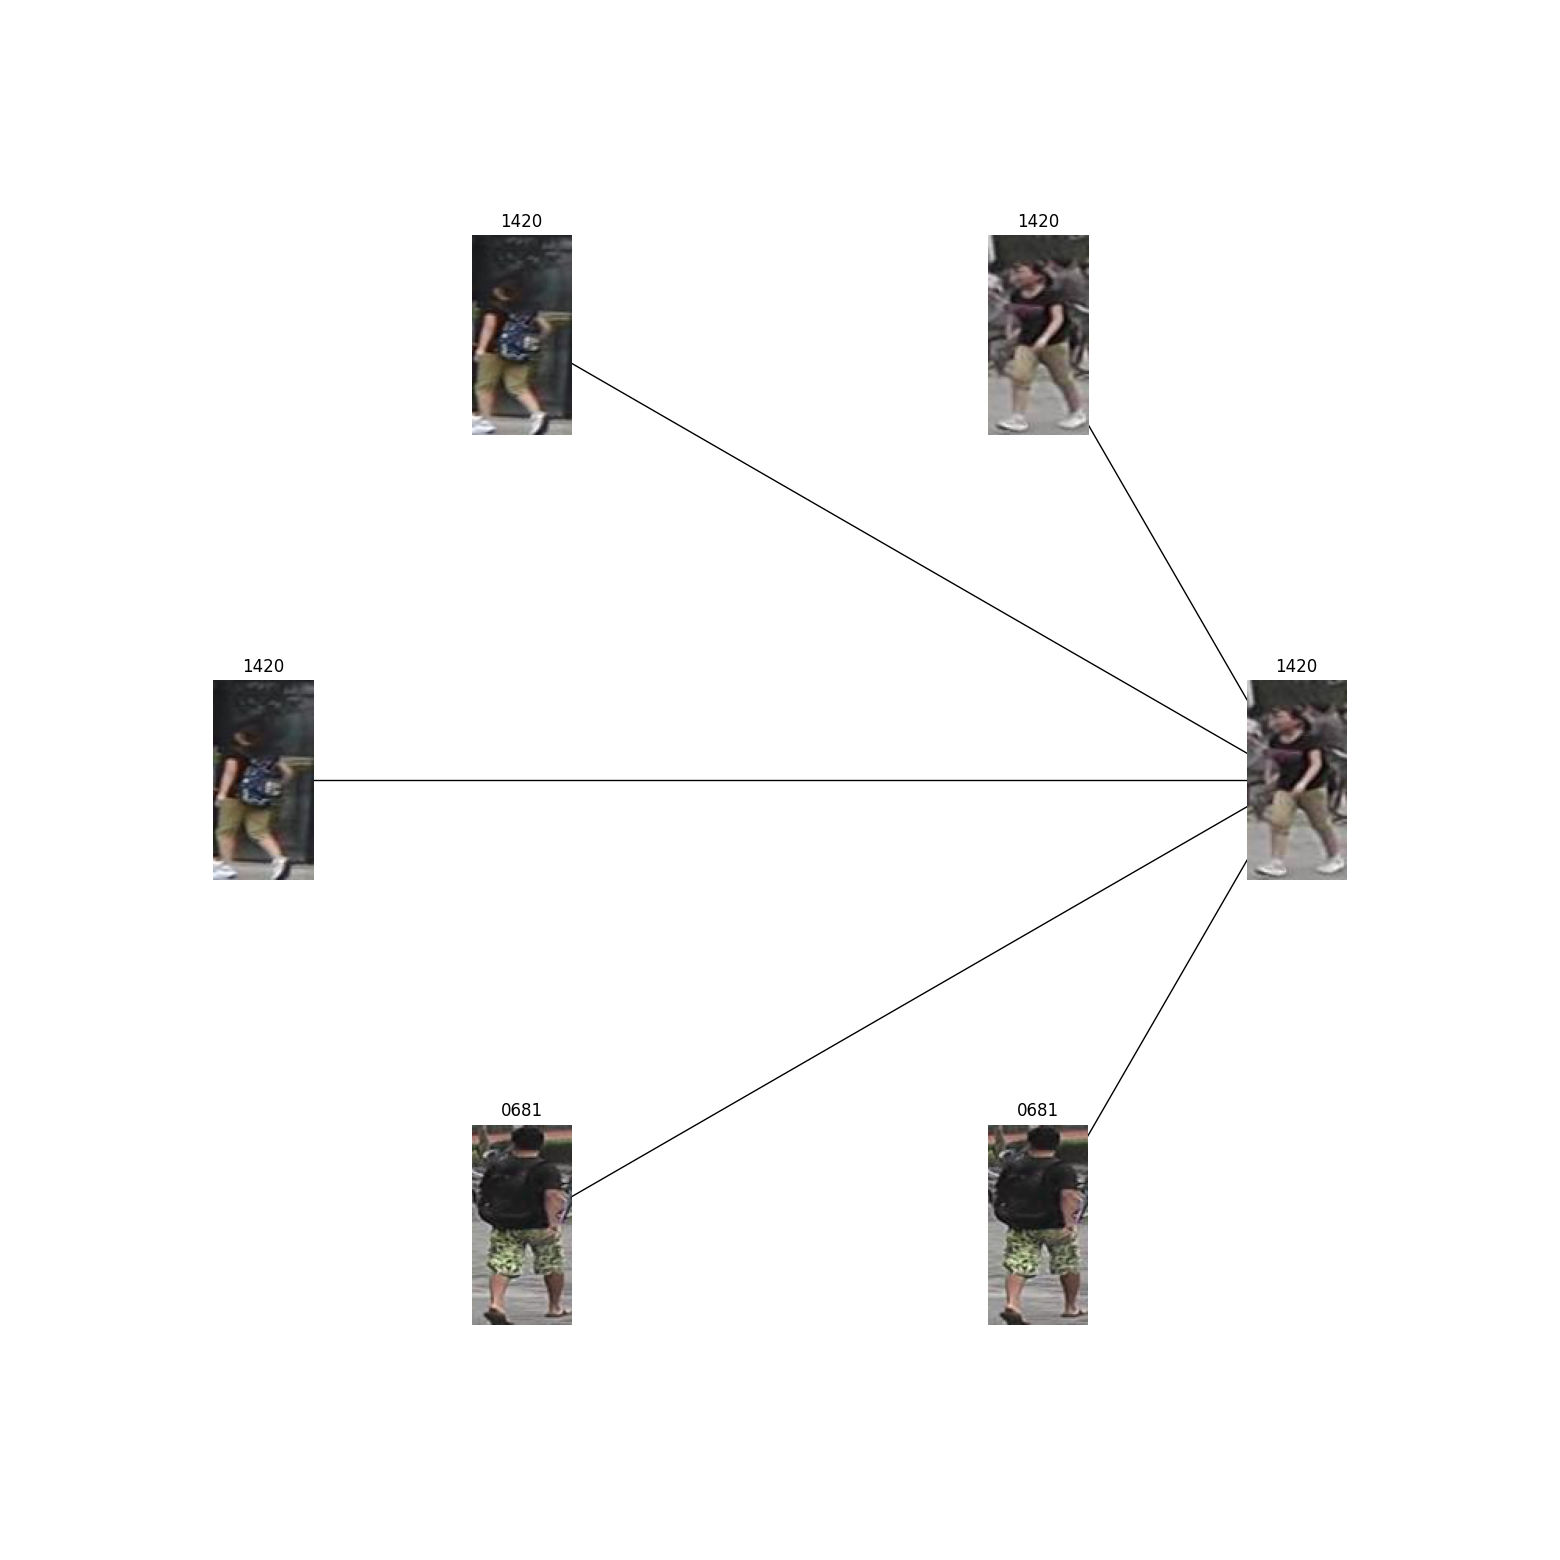

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);